# 2D Cylinder


## Overview

The periodic shedding of laminar flow over a 2D cylinder at a Reynolds Number of 150 can be used to verify the time accuracy of the solver.  For this case the shedding frequency is measured by monitoring the variation in pressure downstream of the cylinder and away from the centre of the wake so that it is not affected by the vortex shed by the opposite side.

## References

http://www.grc.nasa.gov/WWW/wind/valid/lamcyl/Study1_files/Study1.html  









## Define Data Location

For remote data the interaction will use ssh to securely interact with the data
This uses the reverse connection capability in paraview so that the paraview server can be submitted to a job scheduler
Note: The default paraview server connection will use port 11111

In [1]:
remote_data = True
remote_server_auto = True

case_name = 'cylinder'
data_dir='/gpfs/thirdparty/zenotech/home/dstandingford/VALIDATION/CYLINDER'
data_host='dstandingford@vis03'
paraview_cmd='mpiexec /gpfs/cfms/apps/zCFD/bin/pvserver'

if not remote_server_auto:
    paraview_cmd=None

if not remote_data:
    data_host='localhost'
    paraview_cmd=None

## zCFD Validation and Regression¶

In [2]:
# Validation criteria setup for cylinder
validate = True
regression = True
if (validate):
    valid = True
    valid_lower_strouhal = 0.1790
    valid_upper_strouhal = 0.1820
    print 'VALIDATING CYLINDER CASE'
    
if (regression):
    print 'REGRESSION CYLINDER CASE'


VALIDATING CYLINDER CASE
REGRESSION CYLINDER CASE


## Initialise Environment

In [3]:
%pylab inline
from paraview.simple import *
paraview.simple._DisableFirstRenderCameraReset()
import pylab as pl
import math

Populating the interactive namespace from numpy and matplotlib
paraview version 4.2.0-77-g31a1d2a


## Data Connection

This starts paraview server on remote host and connects

In [4]:
from zutil.post import pvserver_connect
if remote_data:
    pvserver_connect(data_host=data_host,data_dir=data_dir,paraview_cmd=paraview_cmd)

Testing passwordless ssh access
-> Passed
Attempting to find unused port
[dstandingford@vis03] Executing task 'run_uname'
Selected Port: 12000
Starting pvserver connect
[dstandingford@vis03] Executing task 'port_test'
Starting pvserver process
[dstandingford@vis03] Executing task 'pvserver'
[dstandingford@vis03] run: /bin/bash -l -c "cd /gpfs/thirdparty/zenotech/home/dstandingford/VALIDATION/CYLINDER && sleep 2;mpiexec /gpfs/cfms/apps/zCFD/bin/pvserver -rc --client-host=localhost -sp=12000"
[dstandingford@vis03] out: 
[dstandingford@vis03] out: 		   _____ ______ __  __  _____ 
[dstandingford@vis03] out: 		  / ____|  ____|  \/  |/ ____|
[dstandingford@vis03] out: 		 | |    | |__  | \  / | (___  
[dstandingford@vis03] out: 		 | |    |  __| | |\/| |\___ \ 
[dstandingford@vis03] out: 		 | |____| |    | |  | |____) |
[dstandingford@vis03] out: 		  \_____|_|    |_|  |_|_____/ 
[dstandingford@vis03] out: 
[dstandingford@vis03] out: ++++++++++++++++++++++++++++: System Data :++++++++++++++++++

## Get control dictionary¶

In [5]:
from zutil.post import get_case_parameters,print_html_parameters
parameters=get_case_parameters(case_name,data_host=data_host,data_dir=data_dir)

## Get status file

In [6]:
from zutil.post import get_status_dict
status=get_status_dict(case_name,data_host=data_host,data_dir=data_dir)
num_procs = str(status['num processor'])

## Define test conditions

In [7]:
# print parameters
from IPython.display import HTML
HTML(print_html_parameters(parameters))

diameter = 1.0
time_step = parameters['time marching']['unsteady']['time step']
cycles = parameters['time marching']['cycles']
mach = parameters['IC_1']['V']['Mach']
print 'mach = %.2f'%(mach)
kappa = 1.402
print 'kappa = %.3f'%(kappa)
R = 287.058
print 'R = %.3f'%(R)
temperature = parameters['IC_1']['temperature']
print 'temperature = %.2f'%(temperature) + ' Kelvin'
pressure = parameters['IC_1']['pressure']
print 'pressure = %.2f'%(pressure) + ' Pascals'
density = pressure/(R*temperature)
print 'density = %.2f'%(density) + ' kg/m^3'
speed_of_sound = sqrt(kappa*pressure/density)
print 'speed_of_sound = %.2f'%(speed_of_sound) + ' m/s'
u_ref = mach*speed_of_sound 
print 'u_ref = %.2f'%(u_ref) + ' m/s'

mach = 0.20
kappa = 1.402
R = 287.058
temperature = 277.78 Kelvin
pressure = 101325.00 Pascals
density = 1.27 kg/m^3
speed_of_sound = 334.35 m/s
u_ref = 66.87 m/s


## Plot pressure time-history at probe point

/Applications/paraview.app/Contents/Python/paraview/vtk/numpy_interface/dataset_adapter.py:126: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if array == None:


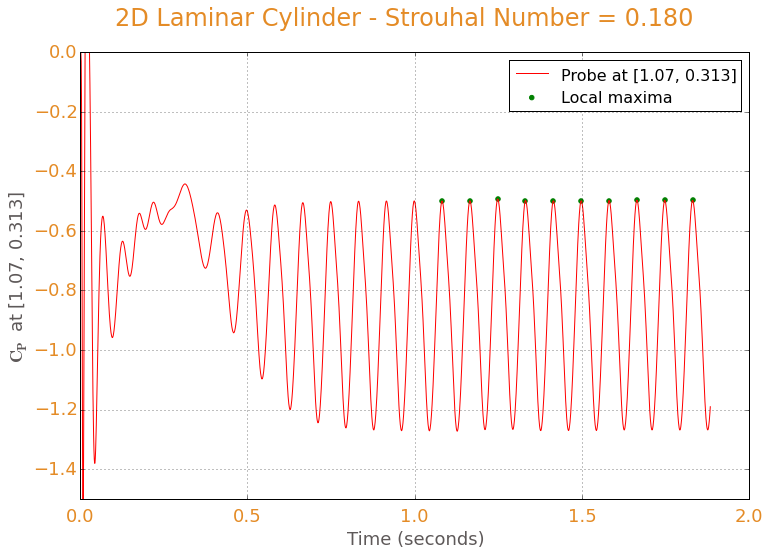

/Users/David/Documents/zPost/ipynb/CYLINDER/images/cylinder_probe.png

In [8]:
from zutil.post import get_case_root, get_case_report, get_monitor_data
monitor_data = get_monitor_data(get_case_report(case_name),'probe','cp')

# clean up the probe history - remove the pseudo-timestep data
probe_data_x = []
probe_data_y = []
for i in range(0,len(monitor_data[0])):
    if ((float(monitor_data[0][i])/float(cycles)) == int(monitor_data[0][i]/cycles)):
        probe_data_x.append(float(monitor_data[0][i])*float(time_step)/float(cycles))
        probe_data_y.append(float(monitor_data[1][i]))
        
# Find local maxima after 1 second
maxima_x = []
maxima_y = []
time_start = 1.0
for i in range(1,len(probe_data_x)-1):
    time = probe_data_x[i]
    if (time > time_start):
        val_im1 = probe_data_y[i-1]
        val_i   = probe_data_y[i]
        val_ip1 = probe_data_y[i+1]
        if ((val_i > val_im1) and (val_i > val_ip1)):
            maxima_x.append(probe_data_x[i])
            maxima_y.append(probe_data_y[i])

# Calculate the Strouhal number
num_periods = len(maxima_x)-1
if (num_periods > 1):
    frequency = num_periods/(maxima_x[len(maxima_x)-1]-maxima_x[0])
    strouhal = frequency*diameter/u_ref
else:
    print 'INSUFFICIENT NUMBER OF PERIODS'
    strouhal = -100.0
    if (validate):
        valid = False
        
fig = pl.figure(figsize=(12, 8), dpi=150, facecolor='w', edgecolor='#E48B25')
fig.suptitle('2D Laminar Cylinder - Strouhal Number = ' + '%.3f'%strouhal, 
             fontsize=24, fontweight='normal', color = '#E48B25')

ax = fig.add_subplot(1,1,1)
ax.grid(True)
ax.set_xlabel('Time (seconds)', fontsize=18, fontweight='normal', color = '#5D5858')
ax.set_ylabel(r'$\mathbf{C_P}$' + ' at [1.07, 0.313]', fontsize=18, fontweight='normal', color = '#5D5858')
ax.set_xlim((0.0,2.0))
ax.set_ylim((-1.5,0.0))
ax.plot(probe_data_x, probe_data_y, color='r', label='Probe at [1.07, 0.313]')
ax.scatter(maxima_x, maxima_y, color='g', label='Local maxima')
legend = ax.legend(loc='best', scatterpoints=1, numpoints=1, shadow=False, fontsize=16)
legend.get_frame().set_facecolor('white')
ax.tick_params(axis='x', pad=8)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(18) 
    tick.label.set_fontweight('normal') 
    tick.label.set_color('#E48B25')

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(18)
    tick.label.set_fontweight('normal') 
    tick.label.set_color('#E48B25') 

fig.savefig("images/cylinder_probe.png")
show()
from IPython.display import FileLink, display 
display(FileLink('images/cylinder_probe.png'))

## Convergence

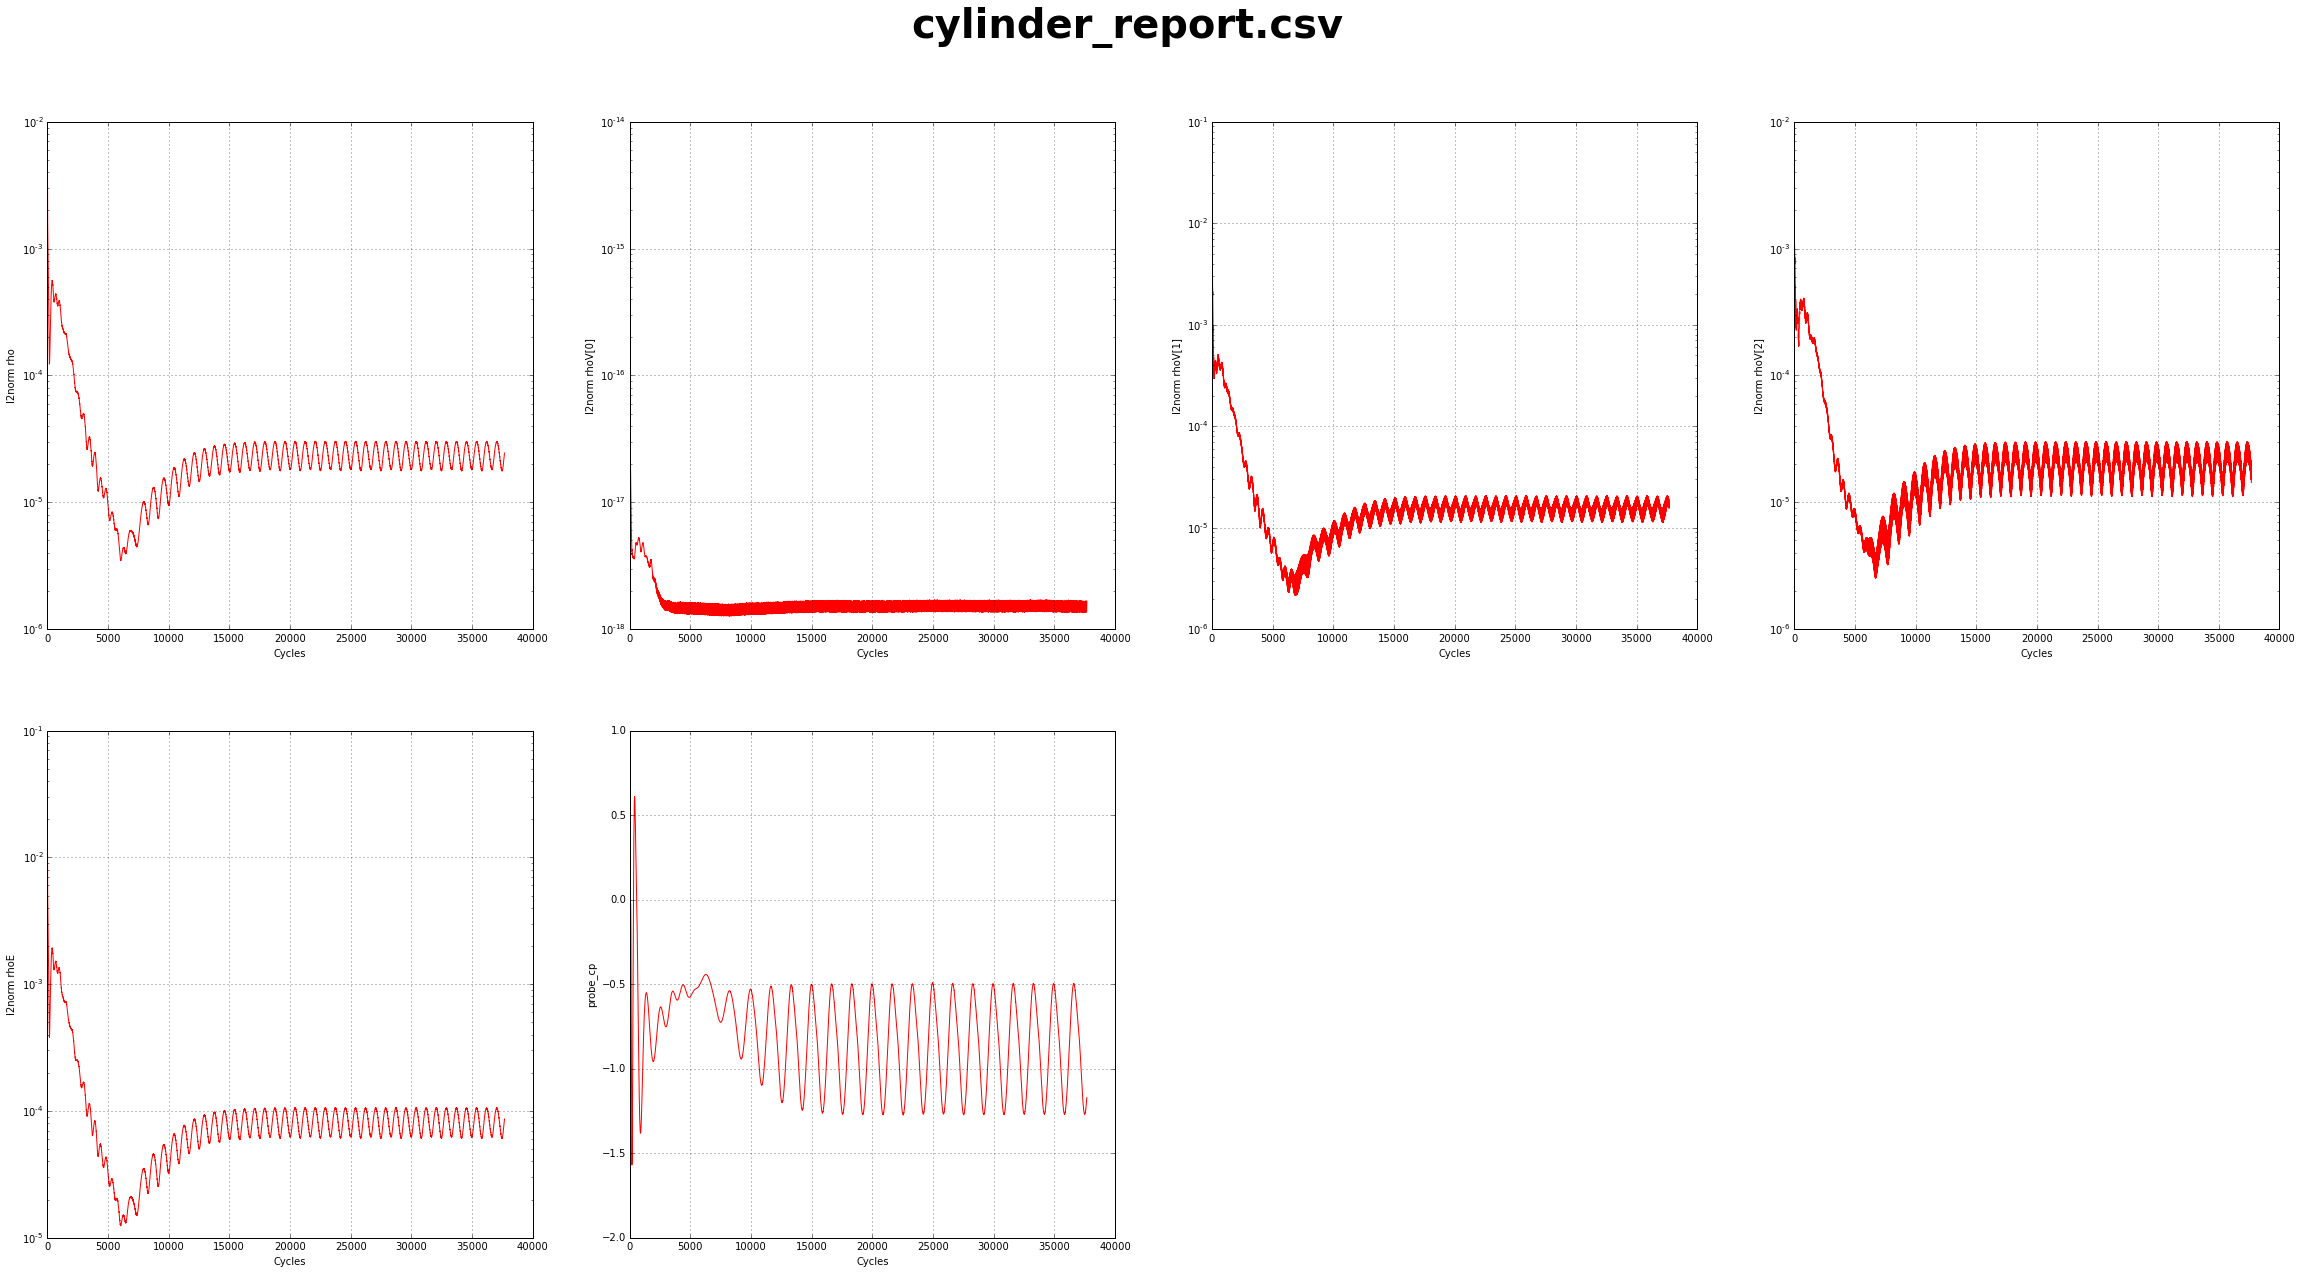

In [9]:
from zutil.post import residual_plot, get_case_report
residual_plot(get_case_report(case_name))
show()

## Validation and regression

In [10]:
# define function to help with validation check
def validate_data(name, value, valid_lower, valid_upper):
    if ((value < valid_lower) or (value > valid_upper)):
        print 'INVALID: ' + name + ' %.4f '%valid_lower + '%.4f '%value + ' %.4f'%valid_upper
        return False
    else:
        return True  
    
if (validate):
    valid = valid and validate_data('strouhal', strouhal, valid_lower_strouhal, valid_upper_strouhal)
    if (valid):
        print 'VALIDATION = PASS :-)'
    else:
        print 'VALIDATION = FAIL :-('   

VALIDATION = PASS :-)


In [11]:
if (regression):
    import pandas as pd
    pd.options.display.float_format = '{:,.6f}'.format
    print 'REGRESSION DATA'
    regress = {'version' : ['v0.0'  , 'v0.1'  , 'CURRENT'], 
               'Strouhal'   : [0.180171, 0.180171, strouhal]}
    regression_table = pd.DataFrame(regress, columns=['version','Strouhal'])
    print regression_table

REGRESSION DATA
   version  Strouhal
0     v0.0  0.180171
1     v0.1  0.180171
2  CURRENT  0.179930


## Cleaning up

In [12]:
if remote_data:
    print 'Disconnecting from remote paraview server connection'
    Disconnect()

Disconnecting from remote paraview server connection
Exiting...
[dstandingford@vis03] out: 